In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
source = "/scratch/jerome/TimeLapses/2018-07-07-Mortier/"
import glob
images = glob.glob(source+"*.jpg")
images.sort()
print(len(images))

999


In [22]:
import numpy
import json
from PIL import Image
import scipy.ndimage
import pyopencl, os
os.environ["PYOPENCL_COMPILER_OUTPUT"]="1" 
import pyopencl.array as gpuarray
from pyopencl.reduction import ReductionKernel
sRGB0 = raw = numpy.asarray(Image.open(images[0]))
sRGB1 = numpy.asarray(Image.open(images[1]))
shape = raw.shape
print(raw.shape, raw.dtype)

(3264, 4928, 3) uint8


In [5]:
ctx = pyopencl.create_some_context(answers=["0"])#, "0"])
print(ctx)
queue = pyopencl.CommandQueue(ctx, properties = pyopencl.command_queue_properties.PROFILING_ENABLE)

<pyopencl.Context at 0x55e305b07110 on <pyopencl.Device 'GeForce GTX 750 Ti' on 'NVIDIA CUDA' at 0x55e305c2eef0>>


In [6]:
%load_ext pyopencl.ipython_ext

In [53]:
%%cl_kernel

kernel void mean2std(global float* value,
                     global float2* mean,
                     global float* delta2,
                     int size)
{
    int gid = get_global_id(0);
    if (gid>=size)
    {
       return;
    }
    float m = mean[0].s0/mean[0].s1;
    float delta = value[gid] - m;
    delta2[gid] = delta*delta;
}

kernel void sigmaclip(global float* value,
                       global float2* mean,
                       global float2* std,
                       float cutof,                 
                       int size)
{
    int gid = get_global_id(0);
    if (gid>=size)
    {
       return; 
    }
       
    float m = mean[0].s0/mean[0].s1;
    float s = sqrt(std[0].s0/(std[0].s1-1.0f));
    if (fabs(value[gid]-m)>(cutof*s))
    {
        value[gid] = NAN;
    }
}

static float dec_sRGB(uchar value)
{
    float res, a=0.055f, gamma=2.4f,slope=12.92f; 
    if (value<=10)
        res = (float)value/255.0/slope;
    else
        res = pow(((float)value/255.0f + a)/(1.0f+a), gamma);
    return res;
}

static uchar comp_sRGB(float value)
{
    float a=0.055f, gamma=2.4f,slope=12.92f, c=0.0031308f; 
    float res;
    if (value<=c)
        res = value*slope;
    else
        res = (1.0f+a) * powr(value, 1.0f/gamma) - a;
    if (res<0.0f)
        res = 0.0f;
    else if (res>1.0f)
        res = 255.0f;
    else
        res = 255.0f*res + 0.5f;
    
    return (uchar) res;
}

static float comp_L(float value)
{ //https://fr.wikipedia.org/wiki/CIE_L*a*b*

    float epsilon = 216.0f/24389.0f,
          kappa = 24389.0f/27.0f,
          res;
    if (value>epsilon)
        res = pow(value, 1.0f/3.0f);
    else
        res = (kappa * value + 16.0f)/ 116.0f;
    return res;
}

static float dec_L(float value)
{
    float d = 6.0f/29.0f, res;
    if (value>d)
        res = pown(value, 3);
    else
        res = (value - 4.0f/29.0f) * 3.0f * d * d;
    return res;
}

static float3 XYZ2Lab(float3 XYZ)
{
    float3 Lab, 
           D65 = (float3)(0.9504f,  1.0000f, 1.0888f),
           xyz = XYZ/D65,
           fxyz = (float3)(comp_L(xyz.x), comp_L(xyz.y), comp_L(xyz.z));
    Lab = (float3)(116.0f * fxyz.y - 16.0f,
                   500*(fxyz.x - fxyz.y),
                   200*(fxyz.y - fxyz.z));
    return Lab;
}

static float3 Lab2XYZ(float3 Lab)
{
    float3 D65 = (float3)(0.9504f,  1.0000f, 1.0888f),
           xyz;
    float l;
           
    l = (Lab.x + 16.0f)/116.0f;
    xyz = (float3)(dec_L(l + Lab.y/500.0f),
                   dec_L(l),
                   dec_L(l - Lab.z/200.0f));
    return xyz * D65;
}

static float3 RGB2XYZ(float3 RGB)
{
    //const float matrix[9] = {0.4124f, 0.3576f, 0.1805f, 0.2126f, 0.7152f, 0.0722f, 0.0193f, 0.1192f, 0.9505f};
    const float3 to_X = (float3)(0.4124f, 0.3576f, 0.1805f);
    const float3 to_Y = (float3)(0.2126f, 0.7152f, 0.0722f);
    const float3 to_Z = (float3)(0.0193f, 0.1192f, 0.9505f);
    return (float3)(dot(RGB, to_X), dot(RGB, to_Y), dot(RGB, to_Z));
}

static float3 XYZ2RGB(float3 XYZ)
{
    //const float matrix[9] = {3.2410f, -1.5374f, -0.4986f, -0.9692f,  1.8760f,  0.0416f, 0.0556f, -0.2040f,  1.0570f};
    const float3 to_R = (float3)( 3.2410f,-1.5374f,-0.4986f),
                 to_G = (float3)(-0.9692f, 1.8760f, 0.0416f),
                 to_B = (float3)( 0.0556f,-0.2040f,1.0570f);
    return (float3)(dot(XYZ, to_R), dot(XYZ, to_G), dot(XYZ, to_B));
}


kernel void decompress_sRGB(global uchar *sRGB, global float *RGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB[i] = dec_sRGB(sRGB[i]);
        RGB[i+1] = dec_sRGB(sRGB[i+1]);
        RGB[i+2] = dec_sRGB(sRGB[i+2]);
    }
}

kernel void compress_sRGB(global float *RGB, global uchar *sRGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB[i] = comp_sRGB(sRGB[i]);
        RGB[i+1] = comp_sRGB(sRGB[i+1]);
        RGB[i+2] = comp_sRGB(sRGB[i+2]);
    }
}

kernel void sRGB_to_Lab(global uchar *sRGB, global float *Lab, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB, XYZ, LAB;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB = (float3)(dec_sRGB(sRGB[i]),
                       dec_sRGB(sRGB[i+1]),
                       dec_sRGB(sRGB[i+2]));
        XYZ = RGB2XYZ(RGB);
        LAB = XYZ2Lab(XYZ);
        Lab[i] = LAB.x;
        Lab[i+1] = LAB.y;
        Lab[i+2] = LAB.z;
    }
}

kernel void Lab_to_sRGB(global float *Lab, global uchar *sRGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB, XYZ, LAB;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        LAB = (float3)(Lab[i], Lab[i+1], Lab[i+2]);
        XYZ = Lab2XYZ(LAB);
        RGB = XYZ2RGB(XYZ);
        sRGB[i] = comp_sRGB(RGB.x);
        sRGB[i+1] = comp_sRGB(RGB.y);
        sRGB[i+2] = comp_sRGB(RGB.z);
    }
}


kernel void convert_color(global float *RGB, global float *XYZ, int width, int height, global float *matrix)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = get_global_id(0) + width * get_global_id(1);
        XYZ[3*i+0] = RGB[3*i]*matrix[0] + RGB[3*i+1]*matrix[1] + RGB[3*i+2]*matrix[2];
        XYZ[3*i+1] = RGB[3*i]*matrix[3] + RGB[3*i+1]*matrix[4] + RGB[3*i+2]*matrix[5];
        XYZ[3*i+2] = RGB[3*i]*matrix[6] + RGB[3*i+1]*matrix[7] + RGB[3*i+2]*matrix[8];
    }
}

kernel void sRGB_to_RGB(global uchar *sRGB, global float *RGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB3;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB3 = (float3)(dec_sRGB(sRGB[i]),
                       dec_sRGB(sRGB[i+1]),
                       dec_sRGB(sRGB[i+2]));
        RGB[i] = RGB3.x;
        RGB[i+1] = RGB3.y;
        RGB[i+2] = RGB3.z;
    }
}

// load a float3 from a given prosition:
static float3 load3(global float* image,
                    int index)
{
    float3 res = (float3)(image[3*index], image[3*index+1], image[3*index+2]);
    return res;
}

//Perform a bilinear interpolation of image with 3 channels
static float3 bilinear3(float2 target, 
                        global float* image,
                        int2 size,
                        float3 fill,
                        int mode) //mode = 1 bilinear or 0 for nearest
{
    int tx_prev = (int) target.x,
        tx_next = tx_prev + 1,
        ty_prev = (int) target.y,
        ty_next = ty_prev + 1;

    float3 interp = fill;

    if (0.0f <= target.x && target.x < (size.x - 1) && 0.0f <= target.y && target.y < (size.y - 1) )
    {
        if (mode == 1) 
        {   //bilinear interpolation: read 4 neighbours
            float3 image_p = load3(image, ty_prev*size.x + tx_prev),
                   image_x = load3(image, ty_prev*size.x + tx_next),
                   image_y = load3(image, ty_next*size.x + tx_prev),
                   image_n = load3(image, ty_next*size.x + tx_next);

            if (tx_next >= size.x) 
            {
                image_x = image_p;
                image_n = image_y;
            }
            if (ty_next >= size.y) {
                image_y = image_p;
                image_n = image_x;
            }

            //bilinear interpolation
            float3 interp1 = ((float) (tx_next - target.x)) * image_p + ((float) (target.x - tx_prev)) * image_x,
                   interp2 = ((float) (tx_next - target.x)) * image_y + ((float) (target.x - tx_prev)) * image_n;

            interp = ((float) (ty_next - target.y)) * interp1 + ((float) (target.y - ty_prev)) * interp2;

        }
        else 
        { //no interpolation TODO: round index !
                interp = load3(image, (int)(target.y + 0.5) * size.x + (int)(target.x + 0.5));
        }
    }
    
    //to be coherent with scipy.ndimage.interpolation.affine_transform
    if (target.x >= (size.x - 1)) 
        interp = fill;
    if (target.y >= (size.y - 1)) 
            interp = fill;
    return interp;
}

static float _lanczos_n(float value, float order)
{
    float res=0.0f;
    if (value == 0)
        res = 1.0f;
    else if (fabs(value)>=order)
        res = 0.0f;
    else
        res = order*sin(M_PI_F*value)*sin(M_PI_F*value/order)/(M_PI_F*M_PI_F*value*value);
    return res;
}

//Perform a lanczos interpolation of image with 3 channels, mode may be 
static float3 lanczos(float2 target, 
                      global float* image,
                      int2 size,
                      float2 scale, 
                      float3 fill,
                      int mode) //mode = 1, 2 or 3 for width of the filter
{
    if ((target.x < 0)||target.x > (size.x - 1)||(target.y < 0)||target.y > (size.y - 1))
    {
        return fill;
    }
        
    float4 sum4 = (float4)(0.0f, 0.0f, 0.0f, 0.0f);
    float coef_x, coef_y, coef, fmode=(float) mode;
    int xmin, xmax, ymin, ymax, x, y, idx;
    xmin = max((int)floor(target.x - scale.x * fmode), 0);
    xmax = min((int) ceil(target.x + scale.x * fmode) + 1, size.x);
    ymin = max((int)floor(target.y - scale.y * fmode), 0);
    ymax = min((int) ceil(target.y + scale.y * fmode) + 1, size.y);
    
    for (y=ymin; y<ymax; y++)
    {
        coef_y = _lanczos_n(((float)y-target.y)/scale.y, fmode);
        for (x=xmin; x<xmax; x++)    
        {
            coef_x = _lanczos_n(((float)x-target.x)/scale.x, fmode);
            idx = y * size.x + x;
            coef = coef_x * coef_y;
            if (fabs(coef)>1e-30)
            {
                sum4 += (float4)(load3(image, idx) * coef, coef);
            }
            
        }
    }
    return (float3)(sum4.s0/sum4.s3, sum4.s1/sum4.s3, sum4.s2/sum4.s3);
}

kernel void rotate_image(global float *inp, global float *out, int width, int height, float angle)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float cx = width/2.0f, cy = height/2.0f, xout, yout;
        xout = (float) get_global_id(0);
        yout = (float) get_global_id(1);
        
        float2 target = (float2)(cos(angle)*(xout - cx) + sin(angle)*(yout - cy) + cx,
                                -sin(angle)*(xout - cx) + cos(angle)*(yout - cy) + cy);
        int i = get_global_id(0) + width * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width, height),
                               (float3) (0.0f,0.0f,0.0f),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void unwrap_image(global float *inp, global float *out, 
                         int width_dis, int height_dis,
                         int width_cor, int height_cor,
                         float center_dis_x, float center_dis_y,
                         float center_cor_x, float center_cor_y,
                         float k1, float k2, float k3)
{
    if ((get_global_id(0)<width_cor) && (get_global_id(1) < height_cor))
    {
        float xcor, ycor, r2, correction;
        xcor = (float) get_global_id(0) - center_cor_x;
        ycor = (float) get_global_id(1) - center_cor_y;
        r2 = xcor*xcor + ycor*ycor;
        //K1 = arg[8]*1e-9
        //K2 = arg[9]*1e-15
        //K3 = arg[10]*1e-23
        //return c + (u - c)*
        correction = (1.0f + k1*r2 + k2*r2*r2 + k3*r2*r2*r2);
        float2 target = (float2)(center_dis_x + xcor*correction,
                                 center_dis_y + ycor*correction);
        int i = get_global_id(0) + width_cor * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width_dis, height_dis),
                               (float3) (0.0f,0.0f,0.0f),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void unwrap_rot_image(global float *inp, global float *out, 
                         int width_dis, int height_dis,
                         int width_cor, int height_cor,
                         float center_dis_x, float center_dis_y,
                         float center_cor_x, float center_cor_y,
                         float k1, float k2, float k3, float angle, 
                         float fill)
{
    if ((get_global_id(0)<width_cor) && (get_global_id(1) < height_cor))
    {
        float xcor, ycor, r2, correction, xcorr, ycorr;
        xcor = (float) get_global_id(0) - center_cor_x;
        ycor = (float) get_global_id(1) - center_cor_y;
        r2 = xcor*xcor + ycor*ycor;
        correction = (1.0f + k1*r2 + k2*r2*r2 + k3*r2*r2*r2);
        xcorr = cos(angle) * xcor - sin(angle) * ycor;
        ycorr = sin(angle) * xcor + cos(angle) * ycor;
        float2 target = (float2)(center_dis_x + xcorr*correction,
                                 center_dis_y + ycorr*correction);
        int i = get_global_id(0) + width_cor * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width_dis, height_dis),
                               (float3) (fill, fill, fill),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void decimate(global float *inp, global float *out, 
                      int width_inp, int height_inp,
                      int width_out, int height_out,
                      float offset_x, float offset_y,
                      float decimation_x, float decimation_y,
                      int mode, float fill)
{
    if ((get_global_id(0)<width_out) && (get_global_id(1) < height_out))
    {
        float xin, yin;
        float3 out3;
        xin = (float) get_global_id(0) * decimation_x + offset_x;
        yin = (float) get_global_id(1) * decimation_y + offset_y;
        float2 target = (float2)(xin, yin);
        int i = get_global_id(0) + width_out * get_global_id(1);
        
        if (mode<2)
            out3 = bilinear3(target, 
                             inp,
                             (int2)(width_inp, height_inp),
                             (float3) (fill, fill, fill),
                             mode);
        else
            out3 = lanczos(target, 
                           inp,
                           (int2)(width_inp, height_inp),
                           (float2)(decimation_x, decimation_y), 
                           (float3) (fill, fill, fill),
                           mode);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void sinc(global float* data, float scale, float order)
{
    int center = (get_global_size(0) - 1)/2;
    int pos = get_global_id(0) - center;
    data[get_global_id(0)] = _lanczos_n((float)pos/scale, order);

}

kernel void normalize_LAB(global float *LAB, int width, int height, float normalization)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        LAB[i] /= normalization;
        LAB[i+1] /= normalization;
        LAB[i+2] /= normalization;
    }
}

kernel void delta_LAB(global float *LAB1,
                      global float *LAB2,
                      global float *delta,
                      int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        delta[i/3] = LAB2[i] - LAB1[i];
    }
}

kernel void offset_LAB(global float *LAB,
                       float delta,
                      int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        LAB[i] -=delta;
    }
}

In [16]:
srgb0_d  = gpuarray.empty(queue, shape, raw.dtype)
srgb1_d  = gpuarray.empty(queue, shape, raw.dtype)
srgb2_d  = gpuarray.empty(queue, shape, raw.dtype)
rgb_d  = gpuarray.empty(queue, shape, "float32")
xyz_d  = gpuarray.empty(queue, shape, "float32")
lab0_d  = gpuarray.empty(queue, shape, "float32")
lab1_d  = gpuarray.empty(queue, shape, "float32")
srgb0_d.set(sRGB0)
srgb1_d.set(sRGB1)
#print(srgb_d)
e1 = decompress_sRGB(queue, (sRGB0.shape[1], sRGB0.shape[0]), None, 
                     srgb0_d.data, rgb_d.data, numpy.int32(sRGB0.shape[1]), numpy.int32(sRGB0.shape[0]))
e1.wait()
#RGB2XYZ_d  = gpuarray.empty(queue, 9, "float32")
#XYZ2RGB_d  = gpuarray.empty(queue, 9, "float32")
#RGB2XYZ_d.set(numpy.array([0.4124, 0.3576, 0.1805, 0.2126, 0.7152, 0.0722, 0.0193, 0.1192, 0.9505], "float32"))
#XYZ2RGB_d.set(numpy.array([3.2410, -1.5374, -0.4986, -0.9692,  1.8760,  0.0416,0.0556, -0.2040,  1.0570], "float32"))
#e2=prg.convert_color(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                 rgb_d.data, xyz_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]), RGB2XYZ_d.data)
#e2.wait()

#e3=prg.convert_color(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                 xyz_d.data, rgb_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]), XYZ2RGB_d.data)
#e3.wait()
#e4=prg.compress_sRGB(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                     rgb_d.data, srgb_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]))
#e4.wait()
#srgb_d
print(abs(srgb0_d.get()-raw.astype(int)).max())
print(rgb_d.get()[0,0])

0
[0.21223077 0.41254267 0.783538  ]


In [17]:
delta_d  = gpuarray.empty(queue, shape[:2], "float32")
delta2_d = gpuarray.empty(queue, shape[:2], "float32")
e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb0_d.data, lab0_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
e2 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
e3 = delta_LAB(queue, (shape[1], shape[0]), None, 
                   lab0_d.data, lab1_d.data, delta_d.data,
                   numpy.int32(shape[1]), numpy.int32(shape[0]))

d = delta_d.get()
print(1e-6 * (e1.profile.end - e1.profile.start),
      1e-6 * (e2.profile.end - e2.profile.start),
      1e-6 * (e3.profile.end - e3.profile.start),
     )


23.833375999999998 23.927936 5.881632


<IPython.core.display.Javascript object>


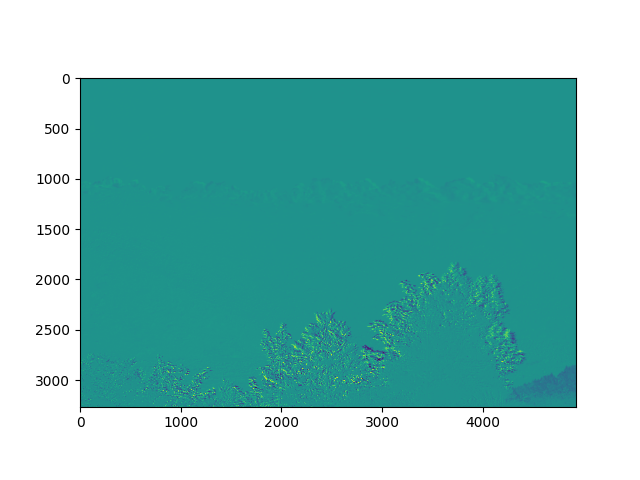

In [18]:
fig,ax=subplots()
ax.imshow(d)

<IPython.core.display.Javascript object>


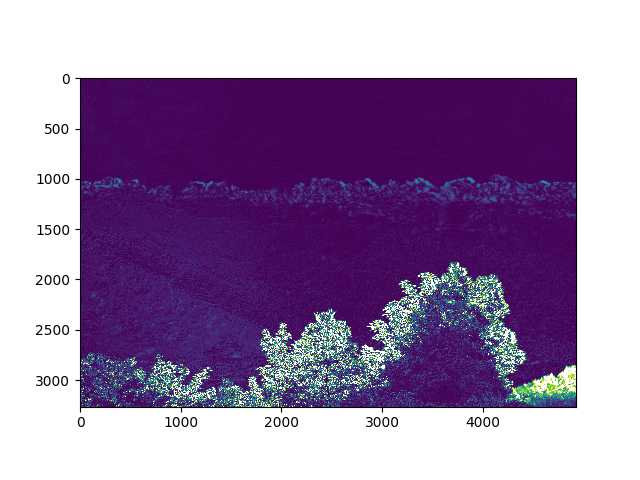

In [19]:
m=d.mean()
s=d.std()
o = abs(d-m)/s
o[(o>3)]=numpy.NAN
fig,ax = subplots()
ax.imshow(o)

In [20]:
e4 = Lab_to_sRGB(queue, (shape[1], shape[0]), None, 
                     lab0_d.data, srgb2_d.data, numpy.int32(shape[1]), numpy.int32(shape[0]))
e4.wait()
#print(srgb_d)
abs(srgb2_d.get()-raw.astype(int)).max()

0

<IPython.core.display.Javascript object>


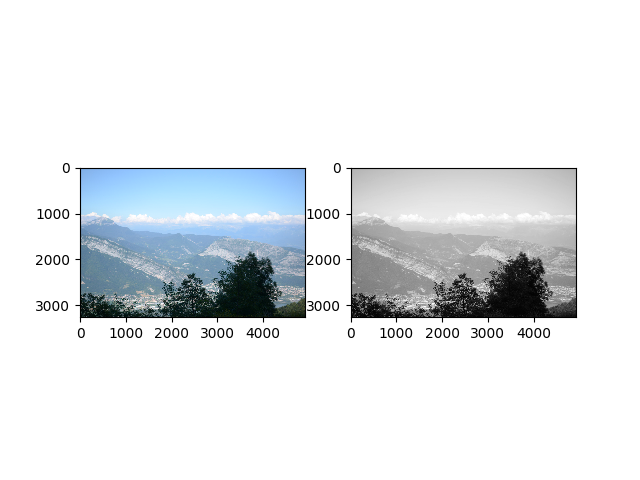

In [24]:
f, ax = subplots(1,2)
ax[0].imshow(srgb2_d.get())
gray = lab0_d.get()[:,:,0]
ax[1].imshow(gray, cmap="gray")

In [25]:
rk1 = ReductionKernel(ctx, dtype_out="float32", neutral=0, reduce_expr="a+b", map_expr="x[i]", 
                      arguments="__global float *x", name="simple_sum_kernel", )
arguments = ("__global float *value",)
float2 = pyopencl.tools.get_or_register_dtype("float2")
map_expr = "isfinite(value[i]) ? (float2)(value[i], 1.0f) : (float2)(0.0f, 0.0f)"
reduce_expr = "a+b"
neutral = "(float2)(0.0f,0.0f)"
#output_statement = "value[i] = item.s0; index[i+1] = item.s1;"
rk2 = ReductionKernel(ctx, dtype_out=float2, neutral=neutral, reduce_expr=reduce_expr, 
                      map_expr=map_expr, 
                      arguments=arguments, 
                      name="counter_sum_kernel", )


In [26]:
def sigma_clip_np(data, cutof=3):
    ldata = data.copy()
    first_size = current_size = numpy.isfinite(ldata).sum()
    last_size = current_size+1

    while last_size>current_size:
        last_size = current_size
        m = numpy.nanmean(ldata)
        s = numpy.nanstd(ldata)
        ldata[abs(ldata-m)>cutof*s] = numpy.nan
        current_size = numpy.isfinite(ldata).sum()
        print(current_size)
    print(first_size, current_size)
    return m,s

In [27]:
%%time 
sigma_clip_np(d)

15580166


/opt/VirtualEnv/py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


15027124
14532214
14119782
13822292
13626981
13510617
13446420
13405245
13380305
13363770
13352006
13342477
13335532
13330876
13327972
13326209
13325093
13324397
13324035
13323698
13323598
13323543
13323536
13323534
13323534
16084992 13323534
CPU times: user 4.63 s, sys: 1.4 s, total: 6.03 s
Wall time: 6.05 s


(0.39959487, 0.6294556)

In [38]:
def sigma_clip_cl(data, cutof=3):
    if isinstance(data, gpuarray.Array):
        delta_d = data
    else:
        delta_d.set(data)
    size = data.size
    res, evt = rk2(delta_d, return_event=True)
    mm = res.get()
    first_size = current_size = mm["s1"]
    last_size = current_size +1
    while last_size>current_size:
        evt2 = mean2std(queue, (size,), None, delta_d.data, res.data, delta2_d.data, numpy.int32(size))
        res2, evt3 = rk2(delta2_d, return_event=True, wait_for=[evt2])
        evt4 = sigmaclip(queue, (size,), None, delta_d.data, res.data, res2.data, numpy.float32(cutof), numpy.int32(size))
        m = mm["s0"]/mm["s1"]
        v = res2.get()
        s = numpy.sqrt(v["s0"]/(v["s1"]-1.0))        
        last_size = current_size
        res, evt = rk2(delta_d, return_event=True)
        mm = res.get()
        current_size = mm["s1"]
        #print(current_size)

    #print(first_size, current_size)
    return m,s

In [39]:
%%time 
sigma_clip_cl(delta_d)

CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 12.8 ms


(0.3995948, 0.6294558683519172)

In [37]:
lab1_d.get()[...,0].min()

0.70704323

In [41]:
delta_L = {images[0]: 0}
results = [0]
current = images[0]
srgb0_d.set(numpy.asarray(Image.open(current)))
e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb0_d.data, lab0_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))

for img in images[1:]:
    srgb1_d.set(numpy.asarray(Image.open(img)))
    e2 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    e3 = delta_LAB(queue, (shape[1], shape[0]), None, 
                   lab0_d.data, lab1_d.data, delta_d.data,
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    m, s = sigma_clip_cl(delta_d)
    print(img, m, s)
    results.append(m)
    delta_L[img]=m

    srgb0_d, srgb1_d = srgb1_d, srgb0_d
    lab0_d, lab1_d = lab1_d, lab0_d


/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-18h06m14-NIKON_D5100.jpg 0.3995948 0.6294558683519172
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-18h06m59-NIKON_D5100.jpg -0.51219004 0.4777008288813052
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-18h07m44-NIKON_D5100.jpg -0.0069371243 0.3570318081870838
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-18h08m29-NIKON_D5100.jpg -0.022728598 0.33284928601772984
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-18h09m14-NIKON_D5100.jpg -0.07600568 0.35035775415343134
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-18h09m59-NIKON_D5100.jpg 0.6434848 0.41394214885355246
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-18h10m44-NIKON_D5100.jpg -0.97898877 0.536099187495303
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-18h11m29-NIKON_D5100.jpg 0.60364157 0.6954053508481527
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-18h12m14-NIKON_D5100.jpg 0.406813 0.545

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h00m59-NIKON_D5100.jpg -0.7033319 0.34480615417801863
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h01m44-NIKON_D5100.jpg 0.49659032 0.3494916063299061
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h02m29-NIKON_D5100.jpg 0.03019858 0.30810699241418615
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h03m14-NIKON_D5100.jpg -0.08457641 0.30695128614125655
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h03m59-NIKON_D5100.jpg 0.07511332 0.30773242464700257
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h04m44-NIKON_D5100.jpg 0.6030365 0.34545955117996896
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h05m29-NIKON_D5100.jpg -0.050853994 0.30233053903895607
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h06m14-NIKON_D5100.jpg 0.48834777 0.3343187577603383
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h06m59-NIKON_D5100.jpg -0.03508939 0.

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h55m44-NIKON_D5100.jpg -0.16874534 0.3095359112432623
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h56m29-NIKON_D5100.jpg -0.011637243 0.29727415772388155
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h57m14-NIKON_D5100.jpg -0.10318412 0.3022221306325338
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h57m59-NIKON_D5100.jpg -0.23081708 0.3202385357033318
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h58m44-NIKON_D5100.jpg -0.14601664 0.3113141511950871
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-19h59m29-NIKON_D5100.jpg -0.1507387 0.30771244332649766
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h00m14-NIKON_D5100.jpg 0.49598005 0.32900541257045374
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h00m59-NIKON_D5100.jpg -0.10272218 0.2912738215854881
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h01m44-NIKON_D5100.jpg -0.071316965

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h50m29-NIKON_D5100.jpg 0.6113621 0.32863739486763177
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h51m14-NIKON_D5100.jpg 0.022884088 0.33928631343838195
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h51m59-NIKON_D5100.jpg -0.48776492 0.4373160912279791
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h52m44-NIKON_D5100.jpg 0.5080134 0.32833036265131227
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h53m29-NIKON_D5100.jpg 0.52928007 0.3269305204480496
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h54m14-NIKON_D5100.jpg 0.52958685 0.3252470525364694
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h54m59-NIKON_D5100.jpg -0.00037298352 0.3288204083011196
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h55m44-NIKON_D5100.jpg -0.014880302 0.31622655107070485
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-20h56m29-NIKON_D5100.jpg -0.104812555

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-21h45m14-NIKON_D5100.jpg -0.1090621 0.49689839175869
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-21h45m59-NIKON_D5100.jpg 0.038297463 0.48878357513995885
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-21h46m44-NIKON_D5100.jpg -0.09225066 0.47574022192554694
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-21h47m29-NIKON_D5100.jpg -0.5646377 0.4343265266365403
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-21h48m14-NIKON_D5100.jpg -0.69727397 0.43961405954643895
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-21h48m59-NIKON_D5100.jpg -0.09419388 0.4036819006936502
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-21h49m44-NIKON_D5100.jpg -0.77699345 0.3746128185071872
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-21h50m29-NIKON_D5100.jpg -0.7275224 0.3640860991608662
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-21h51m14-NIKON_D5100.jpg -0.6768109 0.359

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-22h39m59-NIKON_D5100.jpg -0.94645953 0.6988163712398568
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-22h40m44-NIKON_D5100.jpg -0.9649258 0.7199205249214797
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-22h41m29-NIKON_D5100.jpg -0.74463457 0.6563176335114206
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-22h42m14-NIKON_D5100.jpg 0.73821986 0.6529139830564492
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-22h42m59-NIKON_D5100.jpg -2.341942 1.2208462879176765
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-22h43m44-NIKON_D5100.jpg -0.7009139 0.6554435024386582
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-22h44m29-NIKON_D5100.jpg -0.6400237 0.6226520939832184
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-22h45m14-NIKON_D5100.jpg -0.6872147 0.6234039246382442
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-22h45m59-NIKON_D5100.jpg -0.61243236 0.6047521

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-23h34m44-NIKON_D5100.jpg 0.15248965 0.30593991414257593
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-23h35m29-NIKON_D5100.jpg -0.047893018 0.2855727279066593
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-23h36m14-NIKON_D5100.jpg -0.0031460153 0.2743740988564715
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-23h36m59-NIKON_D5100.jpg -0.0033184355 0.27780555957119635
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-23h37m44-NIKON_D5100.jpg -0.02783305 0.2778213425424375
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-23h38m29-NIKON_D5100.jpg -0.057149407 0.2876445427916509
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-23h39m14-NIKON_D5100.jpg 0.03813893 0.28245230664652227
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-23h39m59-NIKON_D5100.jpg 0.028313767 0.28445951719055435
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-07-23h40m44-NIKON_D5100.jpg -0.021

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-00h29m29-NIKON_D5100.jpg 0.011358104 0.27325570382635694
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-00h30m14-NIKON_D5100.jpg 0.10708883 0.29662020095517855
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-00h30m59-NIKON_D5100.jpg -0.020621374 0.2761901642765028
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-00h31m44-NIKON_D5100.jpg 0.04590631 0.2793278132068892
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-00h32m29-NIKON_D5100.jpg -0.088782676 0.2969591499276357
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-00h33m14-NIKON_D5100.jpg 0.0748348 0.29125798410137355
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-00h33m59-NIKON_D5100.jpg 0.018001577 0.2781355791118931
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-00h34m44-NIKON_D5100.jpg -0.10318498 0.29322388172996705
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-00h35m29-NIKON_D5100.jpg -0.010470217

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-01h24m14-NIKON_D5100.jpg 0.056624357 0.274945246682808
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-01h24m59-NIKON_D5100.jpg 1.0952971 0.6822023866890096
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-01h25m44-NIKON_D5100.jpg -1.0417172 0.6829502905398057
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-01h26m29-NIKON_D5100.jpg -0.0897544 0.28904060104826584
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-01h27m14-NIKON_D5100.jpg 0.021101398 0.2660474387224281
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-01h27m59-NIKON_D5100.jpg -0.0063424385 0.28018474664296267
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-01h28m44-NIKON_D5100.jpg 0.024817102 0.28861847701686594
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-01h29m29-NIKON_D5100.jpg 0.03504686 0.2758649612384425
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-01h30m14-NIKON_D5100.jpg -0.041219734 0.

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-02h18m59-NIKON_D5100.jpg 0.021562824 0.26981890241526685
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-02h19m44-NIKON_D5100.jpg 0.0038927158 0.26815434666634264
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-02h20m29-NIKON_D5100.jpg 0.029487317 0.2663517467091348
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-02h21m14-NIKON_D5100.jpg -0.025225338 0.27231646327188874
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-02h21m59-NIKON_D5100.jpg 0.0042848284 0.27900356932715187
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-02h22m44-NIKON_D5100.jpg 0.0958106 0.29291942774562507
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-02h23m29-NIKON_D5100.jpg 0.061205205 0.2812397463413452
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-02h24m14-NIKON_D5100.jpg -0.10406652 0.2892540812687775
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-02h24m59-NIKON_D5100.jpg 0.111625

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-03h13m44-NIKON_D5100.jpg 0.05142097 0.3101002367582759
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-03h14m29-NIKON_D5100.jpg 0.0750665 0.3089520819578299
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-03h15m14-NIKON_D5100.jpg -0.049705345 0.3024518260055984
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-03h15m59-NIKON_D5100.jpg 0.075020686 0.3117344627110766
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-03h16m44-NIKON_D5100.jpg 0.0007401529 0.31169005462185717
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-03h17m29-NIKON_D5100.jpg 0.04148993 0.3124965444976217
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-03h18m14-NIKON_D5100.jpg 0.035837203 0.3160714413664729
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-03h18m59-NIKON_D5100.jpg 0.00012407778 0.3104996200412804
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-03h19m44-NIKON_D5100.jpg 0.044407226 0

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-04h08m29-NIKON_D5100.jpg 0.15094931 0.3199711637449037
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-04h09m14-NIKON_D5100.jpg 0.012294631 0.31585947989638613
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-04h09m59-NIKON_D5100.jpg 0.030480165 0.3093092461564879
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-04h10m44-NIKON_D5100.jpg 0.09729794 0.3174317858776616
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-04h11m29-NIKON_D5100.jpg 0.059465047 0.3153098357113143
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-04h12m14-NIKON_D5100.jpg 0.07264107 0.3239921808159344
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-04h12m59-NIKON_D5100.jpg 0.13747808 0.3272955278596353
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-04h13m44-NIKON_D5100.jpg 0.081479296 0.3323925548037152
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-04h14m29-NIKON_D5100.jpg 0.17208783 0.3413

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h03m59-NIKON_D5100.jpg 0.07269797 0.3413672393274856
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h04m44-NIKON_D5100.jpg 0.2231035 0.3630143366926561
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h05m29-NIKON_D5100.jpg 0.6988617 0.5365881719510288
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h06m14-NIKON_D5100.jpg 0.553317 0.4635455282176051
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h06m59-NIKON_D5100.jpg -0.27474406 0.32834936409528304
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h07m44-NIKON_D5100.jpg 1.0903785 0.6968464284205012
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h08m29-NIKON_D5100.jpg -0.19014221 0.3001327253610359
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h09m14-NIKON_D5100.jpg 1.4676901 0.8926769295242073
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h09m59-NIKON_D5100.jpg 0.6846784 0.5275887128562

/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h58m44-NIKON_D5100.jpg 0.1462959 0.24883302974233368
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-05h59m29-NIKON_D5100.jpg -0.21615466 0.2929785254858381
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-06h00m14-NIKON_D5100.jpg 0.13499752 0.24488137103858817
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-06h00m59-NIKON_D5100.jpg 0.13488296 0.24609327079568996
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-06h01m44-NIKON_D5100.jpg 0.08360129 0.22243619606522358
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-06h02m29-NIKON_D5100.jpg 0.062498152 0.21328480200815894
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-06h03m14-NIKON_D5100.jpg 0.11378367 0.24600660332757293
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-06h03m59-NIKON_D5100.jpg 0.036120772 0.1984672848540499
/scratch/jerome/TimeLapses/2018-07-07-Mortier/2018-07-08-06h04m44-NIKON_D5100.jpg 0.39197794 0.4

0.5115978810489294


<IPython.core.display.Javascript object>


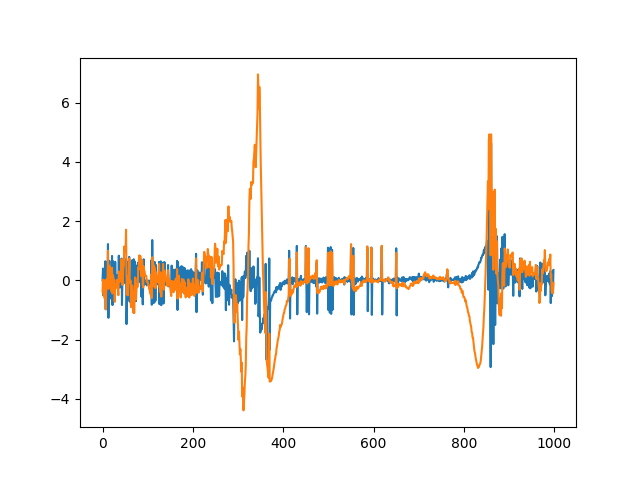

In [72]:
print(numpy.std(results))
fig,ax = subplots()
ax.plot(results, label="raw")
ax.plot(cs-smooth, label="delta_smooth")

<IPython.core.display.Javascript object>


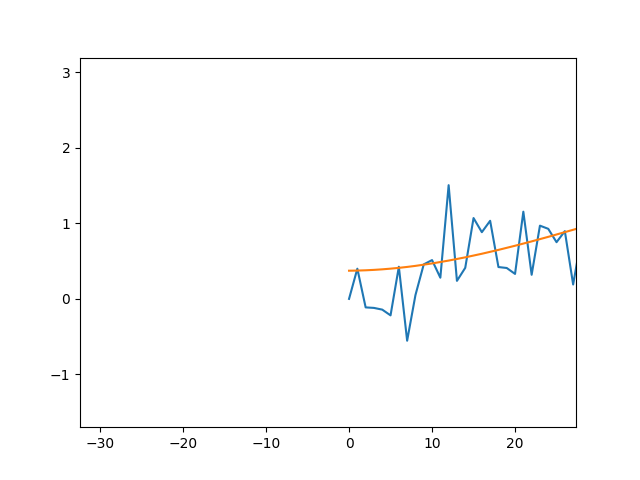

In [47]:
fig,ax = subplots()
cs = numpy.cumsum(results)
from scipy.ndimage import gaussian_filter1d
smooth = gaussian_filter1d(cs, 15)
ax.plot(cs,label="measured")
ax.plot(smooth,label="smoothed")

In [73]:
target = os.path.join(source, "deflicker")
if not os.path.isdir(target):
    os.makedirs(target)
corrections = cs-smooth 

In [65]:
#Not good !
# target = os.path.join(source, "deflicker2")
# if not os.path.isdir(target):
#     os.makedirs(target)
# corrections = smooth - cs

In [67]:
for img, cor in zip(images, corrections):
    srgb1_d.set(numpy.asarray(Image.open(img)))
    e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    e2 = offset_LAB(queue, (shape[1], shape[0]), None, 
                   lab1_d.data, numpy.float32(cor),
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    e3 = Lab_to_sRGB(queue, (shape[1], shape[0]), None, 
                     lab1_d.data, srgb1_d.data, 
                     numpy.int32(shape[1]), numpy.int32(shape[0]))
    Image.fromarray(srgb1_d.get()).save(os.path.join(target, os.path.basename(img)))

In [66]:
os.path.basename(images[0])
print(target)

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker2


In [74]:
# validation of the result:
deflick_images = glob.glob(target+"/*.jpg")
deflick_images.sort()
results_2 = [0]
current = deflick_images[0]
srgb0_d.set(numpy.asarray(Image.open(current)))
e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb0_d.data, lab0_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))

for img in deflick_images[1:]:
    srgb1_d.set(numpy.asarray(Image.open(img)))
    e2 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    e3 = delta_LAB(queue, (shape[1], shape[0]), None, 
                   lab0_d.data, lab1_d.data, delta_d.data,
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    m, s = sigma_clip_cl(delta_d)
    print(img, m, s)
    results_2.append(m)

    srgb0_d, srgb1_d = srgb1_d, srgb0_d
    lab0_d, lab1_d = lab1_d, lab0_d


/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h06m14-NIKON_D5100.jpg 0.046712667 0.6372784015658667
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h06m59-NIKON_D5100.jpg -0.14978513 0.5057246294985642
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h07m44-NIKON_D5100.jpg -0.0062399535 0.38246130999908656
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h08m29-NIKON_D5100.jpg 0.09500129 0.4300889415897369
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h09m14-NIKON_D5100.jpg 0.14447416 0.42913848528508264
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h09m59-NIKON_D5100.jpg -0.0628196 0.45439484217202797
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h10m44-NIKON_D5100.jpg 0.07079741 0.5166791325808802
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h11m29-NIKON_D5100.jpg -0.09147902 0.7199402523756607
/scratch/jerome

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h56m29-NIKON_D5100.jpg -0.019305417 0.4107431968827599
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h57m14-NIKON_D5100.jpg 0.009455998 0.40704890650270026
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h57m59-NIKON_D5100.jpg -0.020505106 0.400414781510522
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h58m44-NIKON_D5100.jpg -0.059006732 0.38657440763231726
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-18h59m29-NIKON_D5100.jpg 0.22711138 0.4032785809174159
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h00m14-NIKON_D5100.jpg -0.024933878 0.3206269466400792
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h00m59-NIKON_D5100.jpg -0.0044726715 0.3666954317193223
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h01m44-NIKON_D5100.jpg -0.19540982 0.37224038306344887
/scratch/

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h46m44-NIKON_D5100.jpg 0.14896363 0.45535036905561677
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h47m29-NIKON_D5100.jpg -0.13109443 0.3321066766603068
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h48m14-NIKON_D5100.jpg -0.09911449 0.3641442753701012
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h48m59-NIKON_D5100.jpg -0.13486335 0.3210110642032473
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h49m44-NIKON_D5100.jpg 0.11554436 0.3743500785154197
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h50m29-NIKON_D5100.jpg 0.025054086 0.42549508664162755
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h51m14-NIKON_D5100.jpg -0.06643314 0.3076919158529646
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-19h51m59-NIKON_D5100.jpg -0.12065199 0.32384722808616895
/scratch/jerome

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-20h36m59-NIKON_D5100.jpg -0.115534805 0.34918770066699695
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-20h37m44-NIKON_D5100.jpg 0.19985732 0.45278298497573666
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-20h38m29-NIKON_D5100.jpg 0.10073109 0.3811222794117883
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-20h39m14-NIKON_D5100.jpg 0.21756198 0.3578129471538399
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-20h39m59-NIKON_D5100.jpg -0.13015014 0.35746026092700905
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-20h40m44-NIKON_D5100.jpg 0.16551346 0.37647347382066443
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-20h41m29-NIKON_D5100.jpg 0.012007391 0.4736253644166844
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-20h42m14-NIKON_D5100.jpg 0.23033202 0.36005945510592074
/scratch/jerome

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-21h27m14-NIKON_D5100.jpg -0.19576716 0.45078026216194234
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-21h27m59-NIKON_D5100.jpg -0.20852561 0.40556458636764403
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-21h28m44-NIKON_D5100.jpg -0.20160729 0.5057327647304243
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-21h29m29-NIKON_D5100.jpg -0.21760872 0.4550222257307615
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-21h30m14-NIKON_D5100.jpg -0.25307637 0.5340687629911058
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-21h30m59-NIKON_D5100.jpg -0.23528469 0.4131374093966763
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-21h31m44-NIKON_D5100.jpg -0.23691028 0.4845369201135041
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-21h32m29-NIKON_D5100.jpg -0.2951249 0.5840499025822002
/scratch/jerome

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-22h17m29-NIKON_D5100.jpg -0.3483689 0.41104371336365514
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-22h18m14-NIKON_D5100.jpg -0.3415625 0.4257429836571439
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-22h18m59-NIKON_D5100.jpg -0.3214764 0.46311357819549576
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-22h19m44-NIKON_D5100.jpg -0.40281934 0.463776612624605
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-22h20m29-NIKON_D5100.jpg -0.45278284 0.42530947313607964
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-22h21m14-NIKON_D5100.jpg -0.4498023 0.40565040562690263
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-22h21m59-NIKON_D5100.jpg -0.41466507 0.42914605960633434
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-22h22m44-NIKON_D5100.jpg -0.51485616 0.43588963650132784
/scratch/jerome

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h07m44-NIKON_D5100.jpg -0.0654529 0.34790327485325107
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h08m29-NIKON_D5100.jpg -0.11300497 0.3299583332910481
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h09m14-NIKON_D5100.jpg -0.09096368 0.3347427672062028
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h09m59-NIKON_D5100.jpg -0.076145254 0.32773594914824916
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h10m44-NIKON_D5100.jpg -0.079501905 0.3266624401682529
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h11m29-NIKON_D5100.jpg -0.18396865 0.41993452102529155
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h12m14-NIKON_D5100.jpg -0.020591225 0.39635264728453184
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h12m59-NIKON_D5100.jpg -0.09312093 0.3811702739809639
/scratch/j

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h57m59-NIKON_D5100.jpg -0.060483787 0.31906536426139703
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h58m44-NIKON_D5100.jpg -0.26152295 0.3291524614177589
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-07-23h59m29-NIKON_D5100.jpg 0.11694982 0.3997403378663789
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h00m14-NIKON_D5100.jpg -0.0017140185 0.3932761289986836
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h00m59-NIKON_D5100.jpg 0.102241054 0.5287756875407755
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h01m44-NIKON_D5100.jpg -0.16747208 0.6769105655941949
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h02m29-NIKON_D5100.jpg -0.043152753 0.31834285825259995
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h03m14-NIKON_D5100.jpg -0.016117191 0.335174345753655
/scratch/je

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h48m14-NIKON_D5100.jpg 0.023633292 0.2727779979140688
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h48m59-NIKON_D5100.jpg 0.0052535567 0.2705159842214222
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h49m44-NIKON_D5100.jpg 0.019788666 0.2731603581666856
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h50m29-NIKON_D5100.jpg 0.014800088 0.2666891063935629
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h51m14-NIKON_D5100.jpg 0.029173741 0.2749249956276844
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h51m59-NIKON_D5100.jpg -0.056398377 0.2847509057085776
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h52m44-NIKON_D5100.jpg 0.015906405 0.2651944211105754
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-00h53m29-NIKON_D5100.jpg 0.0025272488 0.26903066386073576
/scratch/jer

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-01h38m29-NIKON_D5100.jpg 0.027676342 0.27430436385410395
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-01h39m14-NIKON_D5100.jpg -0.019018447 0.2702217252725893
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-01h39m59-NIKON_D5100.jpg -0.0038229756 0.2672876222876664
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-01h40m44-NIKON_D5100.jpg -0.002566272 0.2659264264967048
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-01h41m29-NIKON_D5100.jpg -0.007336237 0.26585458369124787
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-01h42m14-NIKON_D5100.jpg 0.017175619 0.26596852218605077
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-01h42m59-NIKON_D5100.jpg -0.024505978 0.2681553517578522
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-01h43m44-NIKON_D5100.jpg 0.08154883 0.2879181310323367
/scratch

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-02h28m44-NIKON_D5100.jpg 0.009302836 0.3315023628130843
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-02h29m29-NIKON_D5100.jpg 0.045285776 0.3138140793108591
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-02h30m14-NIKON_D5100.jpg 0.30435717 0.38469497324112456
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-02h30m59-NIKON_D5100.jpg 0.04272731 0.3004326604959941
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-02h31m44-NIKON_D5100.jpg 0.033257153 0.2902341413555109
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-02h32m29-NIKON_D5100.jpg 0.035293773 0.313357465758111
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-02h33m14-NIKON_D5100.jpg 0.011465215 0.28362435599792934
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-02h33m59-NIKON_D5100.jpg 0.065868005 0.3078892970395845
/scratch/jerome/T

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-03h18m59-NIKON_D5100.jpg 3.7840753e-05 0.3266865956590043
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-03h19m44-NIKON_D5100.jpg 0.04290811 0.3272465258980069
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-03h20m29-NIKON_D5100.jpg -0.01587183 0.3253083150333442
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-03h21m14-NIKON_D5100.jpg 0.03480981 0.3246310744068359
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-03h21m59-NIKON_D5100.jpg 0.036186785 0.32734048331997384
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-03h22m44-NIKON_D5100.jpg 0.038835898 0.3286014596920813
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-03h23m29-NIKON_D5100.jpg 0.05220683 0.33607851818058465
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-03h24m14-NIKON_D5100.jpg -0.030725572 0.3280723229760025
/scratch/jerom

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-04h09m14-NIKON_D5100.jpg 0.28167707 0.4260726510984762
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-04h09m59-NIKON_D5100.jpg 0.02778147 0.33041246567709875
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-04h10m44-NIKON_D5100.jpg 0.096357755 0.3349703368557546
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-04h11m29-NIKON_D5100.jpg 0.1048771 0.34380850064683105
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-04h12m14-NIKON_D5100.jpg 0.12422011 0.3727654401022733
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-04h12m59-NIKON_D5100.jpg 0.17817853 0.4108120374151755
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-04h13m44-NIKON_D5100.jpg 0.30396524 0.46710286953051455
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-04h14m29-NIKON_D5100.jpg 0.19228919 0.38497132119867916
/scratch/jerome/Time

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h00m14-NIKON_D5100.jpg 0.39829373 0.9359187756659066
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h00m59-NIKON_D5100.jpg 0.52280146 0.5651236494741146
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h01m44-NIKON_D5100.jpg 0.1758153 0.4114394144503839
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h02m29-NIKON_D5100.jpg 0.24766603 0.4185359290857546
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h03m14-NIKON_D5100.jpg 0.4062187 0.37083070151384834
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h03m59-NIKON_D5100.jpg 0.293039 0.4618400275393462
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h04m44-NIKON_D5100.jpg 0.3212884 0.42750116451478765
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h05m29-NIKON_D5100.jpg 0.36327708 0.5313264369768301
/scratch/jerome/TimeLapses/

/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h51m14-NIKON_D5100.jpg 0.06693559 0.2634690755243804
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h51m59-NIKON_D5100.jpg 0.17293525 0.28556408463124877
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h52m44-NIKON_D5100.jpg 0.20352063 0.30494100193122076
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h53m29-NIKON_D5100.jpg 0.13903652 0.3125537581255923
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h54m14-NIKON_D5100.jpg 0.12552564 0.3508533868999649
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h54m59-NIKON_D5100.jpg -0.12707528 0.5523808984493029
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h55m44-NIKON_D5100.jpg 0.084320195 0.34456918910240975
/scratch/jerome/TimeLapses/2018-07-07-Mortier/deflicker/2018-07-08-05h56m29-NIKON_D5100.jpg 0.13677104 0.26487874311190485
/scratch/jerome/Ti

In [75]:
print(numpy.std(results), numpy.std(results_2))

0.5115978810489294 0.2405267848083842


<IPython.core.display.Javascript object>


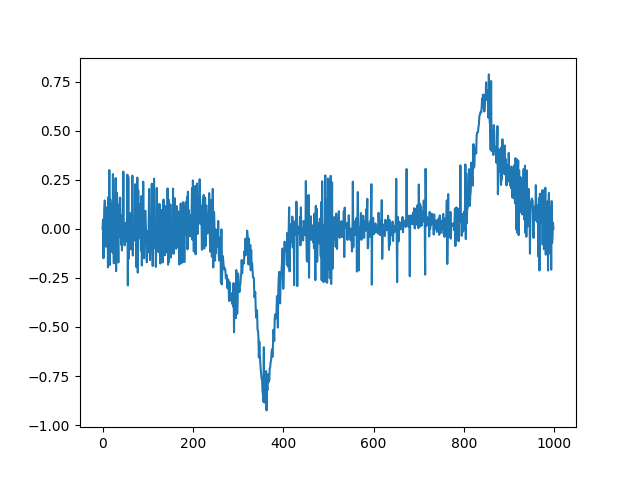

In [76]:
fig,ax = subplots()
ax.plot(results_2)

In [77]:
print(numpy.std(results), numpy.std(results_2), numpy.std(results_3))

0.5115978810489294 0.2405267848083842 0.9077974729061838


<IPython.core.display.Javascript object>


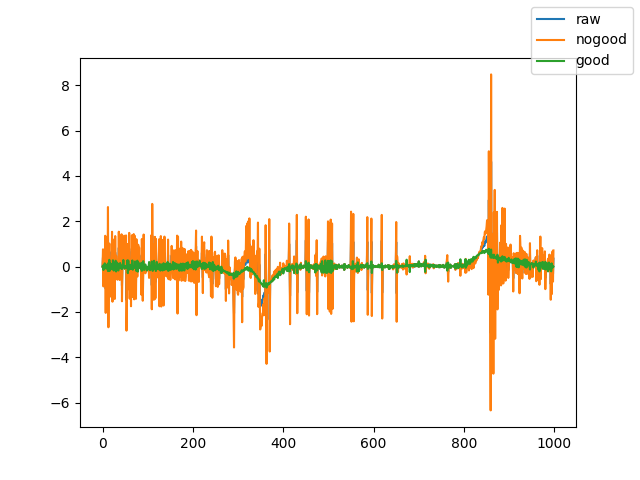

In [79]:
fig,ax = subplots()
ax.plot(results, label="raw")
ax.plot(results_3, label="nogood")
ax.plot(results_2, label="good")
fig.legend()

In [80]:
target = os.path.join(source, "deflick_scaled")
if not os.path.isdir(target):
    os.makedirs(target)
corrections = cs-smooth 

In [83]:
HD = (1080, 1920, 3)
srgb_HD_d = gpuarray.empty(queue, HD, "uint8")
lab_HD_d = gpuarray.empty(queue, HD, "float32")
for img, cor, offset_y in zip(images, corrections, linspace(492,0,len(images))):
    srgb1_d.set(numpy.asarray(Image.open(img)))
    e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    e2 = offset_LAB(queue, (shape[1], shape[0]), None, 
                   lab1_d.data, numpy.float32(cor),
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    e4 = decimate(queue, (HD[1], HD[0]), None,
                  lab1_d.data, lab_HD_d.data,
                  numpy.int32(shape[1]), numpy.int32(shape[0]),
                  numpy.int32(HD[1]), numpy.int32(HD[0]),
                  numpy.float32(0), numpy.float32(offset_y),
                  numpy.float32(2.566666666666667), numpy.float32(2.566666666666667),
                  numpy.int32(3),numpy.int32(0),
                 )
    e3 = Lab_to_sRGB(queue, (HD[1], HD[0]), None, 
                     lab_HD_d.data, srgb_HD_d.data, 
                     numpy.int32(HD[1]), numpy.int32(HD[0]))
    Image.fromarray(srgb_HD_d.get()).save(os.path.join(target, os.path.basename(img)))